In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat, u_darrays
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [ ]:
#CP4 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_zeroRain_gt1k_shear_CP4.p', 'rb'))
#CP25 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_zeroRain_gt1k_shear_CP25.p', 'rb'))
#OBS = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-40_zeroRain_gt5k_-40thresh_OBSera.p', 'rb'))
OBS = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA5_5-20N.p', 'rb'))

In [7]:
print(OBS.keys())

dict_keys(['clon', 't', 'hour', 'clat', 'area', 'q925', 'v925', 'pmax', 'lon', 'pgt01isvalid', 'rh650', 'pmean', 'p', 'u925', 'tmin', 'year', 't650', 'rh925', 'pv925', 'shear', 'month', 'u650', 'q650', 'w650', 'div925', 'lat', 'v650', 'pgt30', 'w925', 'pv650', 'div650', 't925', 'tmean'])


In [8]:
dic = OBS

pp = np.array(dic['pmax'])
sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
umin = np.array(dic['u650'])
umax = np.array(dic['u925'])
qq = np.array(dic['q925']) 
rh = np.array(dic['rh925']) 
tt = np.array(dic['tmin'])
ttm = np.array(dic['tmean'])
month = np.array(dic['month'])
area = np.array(dic['area'])
lat = np.array(dic['clat'])
lon = np.array(dic['clon'])

obs_pcp = {
    'prcp' : pp,
    'u650' : umin,
    'u925' : umax,
    'q925' : qq*1000,
    'rhtot' : rh,
    'shear' : sh*-1,
    'month' : month,
    'area' : area*7.7**2,
    'tmin' : tt,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
obs = pd.DataFrame(obs_pcp)

In [10]:
dic = CP4

pp = np.array(dic['pmax'])
sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
umin = np.array(dic['umin_mid'])
umax = np.array(dic['umax_srfc'])
qq = np.array(dic['qmax']) 
tt = np.array(dic['tmin'])
ttm = np.array(dic['tmean'])
month = np.array(dic['month'])
area = np.array(dic['area'])
lat = np.array(dic['clat'])
lon = np.array(dic['clon'])

cp4_dic = {
    'prcp' : pp,
    'u650' : umin,
    'u925' : umax,
    'q925' : qq*1000,
    'shear' : sh*-1,
    'month' : month,
    'area' : area*4.4**2,
    'tmin' : tt,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
cp4 = pd.DataFrame(cp4_dic)

In [11]:
dic = CP25

pp = np.array(dic['pmax'])
sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
umin = np.array(dic['umin_mid'])
umax = np.array(dic['umax_srfc'])
qq = np.array(dic['qmax']) 
tt = np.array(dic['tmin'])
ttm = np.array(dic['tmean'])
month = np.array(dic['month'])
area = np.array(dic['area'])
lat = np.array(dic['clat'])
lon = np.array(dic['clon'])

cp25_dic = {
    'prcp' : pp*3600,
    'u650' : umin,
    'u925' : umax,
    'q925' : qq*1000,
    'shear' : sh*-1,
    'month' : month,
    'area' : area*25**2,
    'tmin' : tt,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
cp25 = pd.DataFrame(cp25_dic)

(array([ 27., 123., 233., 261., 222., 194., 136.,  94.,  52.,  20.]),
 array([-95.25037713, -89.92533941, -84.6003017 , -79.27526399,
        -73.95022628, -68.62518856, -63.30015085, -57.97511314,
        -52.65007543, -47.32503771, -42.        ]),
 <a list of 10 Patch objects>)

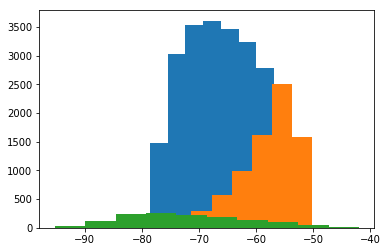

In [12]:
plt.hist(cp4.tmin)
plt.hist(cp25.tmin)
plt.hist(obs.tmin)

(0, 150)

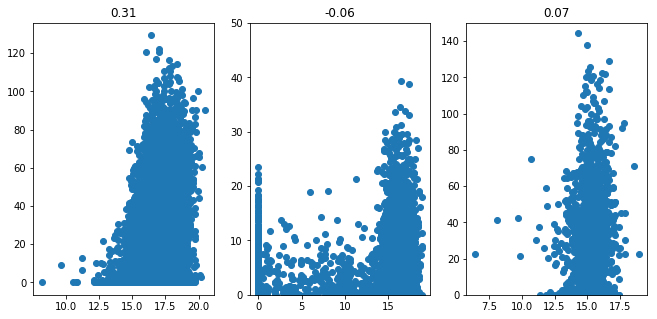

In [14]:
cp4s = [cp4.q925, cp4.prcp]
cp25s = [cp25.q925, cp25.prcp]
obss = [obs.q925, obs.prcp]


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
ax.set_ylim(0,150)
#ax.set_ylim(13,19)


In [15]:
def get_ERA(era, indic, clim=False):

    dic = {}
    dic['u925'] = []
    dic['u650'] = []
    dic['q925'] = []
    dic['q700'] = []
    dic['qtot'] = []
    dic['rhtot'] = []
    dic['rh925'] = []
    for id, date in enumerate(indic.date):
        
        if clim == True:
            getera =np.where((era['time.month']==indic.month[id]) & (era['time.year']==indic.year[id]))

        else:
            getera =np.where((era['time.day']==(indic['date'])[id].day) & (era['time.month']==indic.month[id]) & (era['time.year']==indic.year[id]))

        try:
            era_day = era.isel(time=int(getera[0]))
        except TypeError:
            print('Era missing')
            dic['u925'].append(np.nan)
            dic['u650'].append(np.nan)
            dic['q925'].append(np.nan)
            dic['q700'].append(np.nan)
            dic['qtot'].append(np.nan)
            dic['rhtot'].append(np.nan)

            continue

        elat = indic.clat[id]
        elon = indic.clon[id]
        dic['u925'].append(float(era_day['u'].sel(latitude=elat, longitude=elon, level=925, method='nearest').values))
        dic['u650'].append(float(era_day['u'].sel(latitude=elat, longitude=elon, level=650, method='nearest').values))
        dic['q925'].append(float(era_day['q'].sel(latitude=elat, longitude=elon, level=925, method='nearest').values))
        dic['q700'].append(float(era_day['q'].sel(latitude=elat, longitude=elon, level=700, method='nearest').values))
        dic['rh925'].append(float(era_day['r'].sel(latitude=elat, longitude=elon, level=925, method='nearest').values))
        dic['u_sounding']..append(float(era_day['u'].sel(latitude=elat, longitude=elon, method='nearest').values))
        dic['q_sounding']..append(float(era_day['q'].sel(latitude=elat, longitude=elon, method='nearest').values))
        dic['rh_sounding']..append(float(era_day['r'].sel(latitude=elat, longitude=elon, method='nearest').values))
        
        qtot = era_day['q'].sel(level=slice(700,925)).mean('level')
        dic['qtot'].append(float(qtot.sel(latitude=elat, longitude=elon, method='nearest').values))
        qtot = era_day['r'].sel(level=slice(700,925)).mean('level')
        dic['rhtot'].append(float(qtot.sel(latitude=elat, longitude=elon, method='nearest').values))
    return dic

In [16]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))
pdf = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12))
pdf = pdf.dropna()

ttg = np.array(pdf.tmin, dtype=float)
ttm = np.array(pdf.tmean, dtype=float)
month = pdf.month.values
area = pdf.area.values
area70 = np.array(pdf['70area'], dtype=int)
lat = pdf.clat.values
lon = pdf.clon.values

In [21]:
qera.sel(month=10).mean()

<xarray.DataArray 'q' ()>
array(0.00675, dtype=float32)
Coordinates:
    month    int64 10

In [22]:
# era_out = get_ERA(era, pdf)
# pkl.dump(era_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA.p', 'wb'))

In [23]:
era_out = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA.p', 'rb'))

In [24]:
era_out.keys()

dict_keys(['q700', 'qtot', 'rh925', 'u650', 'q925', 'rhtot', 'u925'])

In [25]:
e_u650 = np.array(era_out['u650'])
e_u925 = np.array(era_out['u925'])
e_q925 = np.array(era_out['q925'])
e_q700 = np.array(era_out['q700'])
e_qtot = np.array(era_out['qtot'])
e_rhtot = np.array(era_out['rhtot'])
e_rh925 = np.array(era_out['rh925'])

In [26]:
e_rhtot.shape

(40751,)

In [27]:
dic = {
    'u650' : e_u650,
    'u925' : e_u925,
    'q925' : e_q925*1000,
    'q700' : e_q700*1000,
    'qtot' : e_qtot*1000,
    'rhtot' : e_rhtot,
    #'rh925' : e_rh925,
    'shear' : (e_u650-e_u925)*-1,
    'month' : month,
    'area' : area*7.7**2,
    'area70' : area70*7.7**2,
    'tmin' : ttg,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
ds = pd.DataFrame(dic)

In [28]:
ds = ds.dropna()

In [29]:
pos1 = (ds.month<=5)  & (ds.u650<0) & (ds.area>=5000)
pos2 = (ds.month>=9)  & (ds.u650<0) & (ds.area>=5000)

opos1 = (obs.month==3)  & (obs.u650<0) & (obs.area>=1000)
opos2 = (obs.month==10)  & (obs.u650<0) & (obs.area>=1000)

cpos1 = (cp4.month<=5)  & (cp4.u650<0) & (cp4.area>=1000) & (cp4.prcp>=0)
cpos2 = (cp4.month>=9)  & (cp4.u650<0) & (cp4.area>=1000) & (cp4.prcp>=0)

cpos125 = (cp25.month<=5)  & (cp25.u650<0) & (cp25.area>=5000) & (cp25.prcp>=0)
cpos225 = (cp25.month>=9)  & (cp25.u650<0) & (cp25.area>=5000) & (cp25.prcp>=0)

In [30]:
np.sum(cpos1)

12304

In [31]:
oposi = (obs.u650<0) & (obs.area>=5000) & (obs.prcp>=1) & ((obs.month>=9) | (obs.month<=5))

cposi4 = (cp4.u650<0) & (cp4.area>=5000) & (cp4.prcp>=1) & ((cp4.month>=9) | (cp4.month<=5))

cposi25 =(cp25.u650<0) & (cp25.area>=5000) & (cp25.prcp>=0.1) & ((cp25.month>=9) | (cp25.month<=5))

(array([ 695., 3224., 3138., 2362., 1916., 1435., 1149.,  936.,  811.]),
 array([  5000.        ,  15555.55555556,  26111.11111111,  36666.66666667,
         47222.22222222,  57777.77777778,  68333.33333333,  78888.88888889,
         89444.44444444, 100000.        ]),
 <a list of 9 Patch objects>)

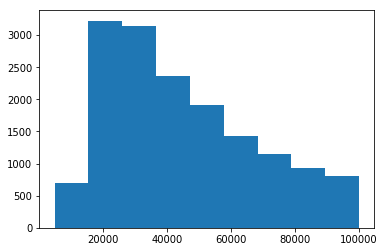

In [32]:
plt.hist(cp4.area, bins=np.linspace(5000,100000,10))

In [33]:
ds_march = ds[pos1]
ds_oct = ds[pos2]
obs_march = obs[opos1]
obs_oct = obs[opos2]
cp4_march = cp4[cpos1]
cp4_oct = cp4[cpos2]
cp25_march = cp25[cpos125]
cp25_oct = cp25[cpos225]

In [34]:
obsp = obs[oposi]
cp4p = cp4[cposi4]
cp25p = cp25[cposi25]

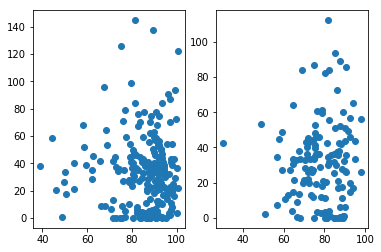

In [35]:
f = plt.figure()
ax = f.add_subplot(121)
plt.scatter(obs_oct.rhtot, obs_oct.prcp)
#plt.xlim(0,150)

ax = f.add_subplot(122)
plt.scatter(obs_march.rhtot, obs_march.prcp)
#plt.xlim(0,150)
#ax.set_ylim(0,130)

(array([ 9.,  5., 10., 12.,  9., 19.,  7., 10.,  5.,  6.,  3.,  3.,  0.,
         1.,  0.,  3.,  3.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([ 10.        ,  14.66666667,  19.33333333,  24.        ,
         28.66666667,  33.33333333,  38.        ,  42.66666667,
         47.33333333,  52.        ,  56.66666667,  61.33333333,
         66.        ,  70.66666667,  75.33333333,  80.        ,
         84.66666667,  89.33333333,  94.        ,  98.66666667,
        103.33333333, 108.        , 112.66666667, 117.33333333,
        122.        , 126.66666667, 131.33333333, 136.        ,
        140.66666667, 145.33333333, 150.        ]),
 <a list of 30 Patch objects>)

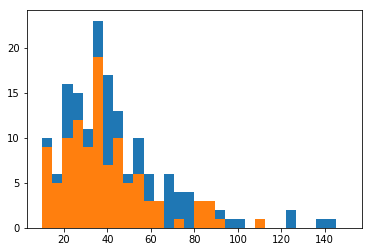

In [37]:
plt.hist(obs_oct.prcp, bins=30, range=(10,150))
plt.hist(obs_march.prcp, bins=30, range=(10,150))

In [38]:
print(np.percentile(obs_march.prcp,90))
print(np.percentile(obs_oct.prcp,90))

59.906640237483174
68.74397024805508


In [54]:
#March oct test
inputs = ds
pos_march = (inputs.month==3)  & (inputs.u650<0) & (inputs.area>=10000) #& (ds.q925>=12.5)
pos_oct = (inputs.month==10)  & (inputs.u650<0) & (inputs.area>=10000)
dss_march = inputs[pos_march]
dss_oct = inputs[pos_oct]

pears (0.21497108973521759, 5.3355271468691504e-30)
pears (0.05339571964219884, 0.0036736516022420535)


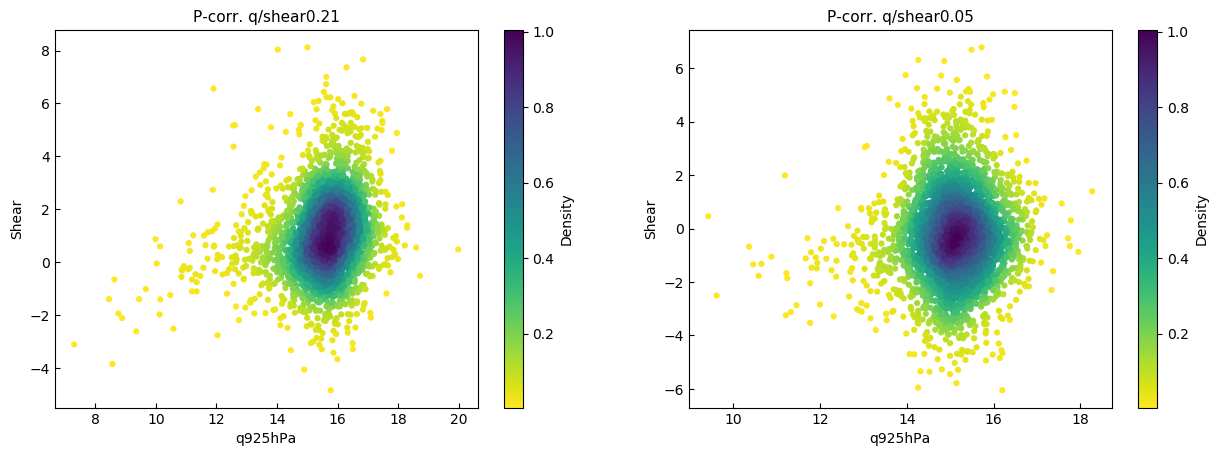

In [60]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

fig = plt.figure(figsize=(15, 5), dpi=100)
cc=11


data1, r1 = density_plot(dss_march.q925, dss_march.u925)

ax1 = fig.add_subplot(121)
mappable = ax1.scatter(dss_march.q925, dss_march.u925, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
#plt.xlim(12,19)
ax1.set_ylabel('Shear')
ax1.set_xlabel('q925hPa')
ax1.set_title('P-corr. q/shear'+str(np.round(r1[0], decimals=2)), fontsize=cc)
ax1.tick_params(direction='in')
cbar = fig.colorbar(mappable)
cbar.set_label('Density')

data1, r1 = density_plot(dss_oct.q925, dss_oct.u925)

ax1 = fig.add_subplot(122)
mappable = ax1.scatter(dss_oct.q925, dss_oct.u925, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
#plt.xlim(12,19)
ax1.set_ylabel('Shear')
ax1.set_xlabel('q925hPa')
ax1.set_title('P-corr. q/shear'+str(np.round(r1[0], decimals=2)), fontsize=cc)
ax1.tick_params(direction='in')
cbar = fig.colorbar(mappable)
cbar.set_label('Density')


In [592]:
cp4.lon.max()

12.901748657226562

In [593]:
def density_plot(v1,v2,v3):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = u_stat.pcor(v1,v2,v3)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

In [594]:
def plot_scatter_month(dat):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.u650, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.u650, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 18)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(223)

    data3, r3 = density_plot(dat.q925, dat.shear, dat.u650)

    mappable = ax2.scatter(dat.q925, dat.shear, c=data3, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 18)
    ax2.set_ylabel('shear')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. qq/shear | umax removed: '+str(np.round(r3[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data4, r4 = density_plot(dat.u925, dat.tmin, dat.u650)

    mappable = ax2.scatter(dat.u925, dat.tmin , c=data4, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(0, 10)
    ax2.set_ylabel('min T')
    ax2.set_xlabel('qmid')
    ax2.set_title('P-corr. qq700/tmin | u650hPa removed: '+str(np.round(r4[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()



In [595]:
def plot_scatter_month_double(dat, dat2):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.shear, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.shear, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax1 = fig.add_subplot(223)

    data1, r1 = density_plot(dat2.shear, dat2.tmin, dat2.q925)

    mappable = ax1.scatter(dat2.shear, dat2.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data2, r2 = density_plot(dat2.q925, dat2.tmin, dat2.shear)

    mappable = ax2.scatter(dat2.q925, dat2.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()

In [596]:
print('Mean storm q, oct', np.mean(ds_oct.q925))
print('Mean storm q, march', np.mean(ds_march.q925))

Mean storm q, oct 15.026176996778801
Mean storm q, march 15.595371407285636


pears (0.1463611288066842, 3.974547518347262e-09)
pears (0.006147014388485875, 0.805802621713267)
pears (0.3179524272855945, 5.8424315673662284e-39)
pears (-0.026339177247851033, 0.29207284000642825)


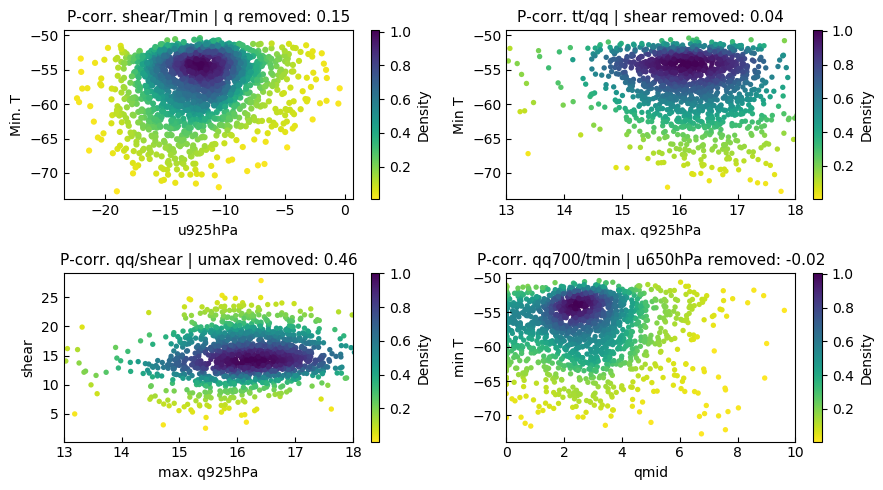

In [597]:
plot_scatter_month(cp25_oct)

pears (-0.18011087643397025, 2.76356653404018e-111)
pears (-0.08921940988879681, 2.592889096401661e-28)
pears (-0.14925605321858718, 2.920322274841764e-23)
pears (-0.08017364407157095, 1.0637420748910533e-07)


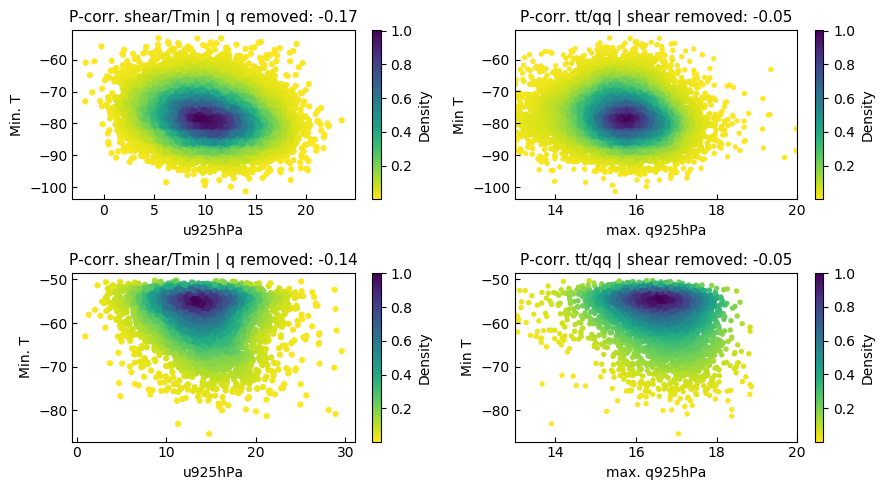

In [598]:
plot_scatter_month_double(ds_march, cp25_march)

pears (-0.1233494698676231, 4.389511677792198e-43)
pears (-0.10137624040214407, 1.3837633911419267e-29)
pears (-0.11307144642566294, 5.713939226914597e-06)
pears (0.006147014388485875, 0.805802621713267)


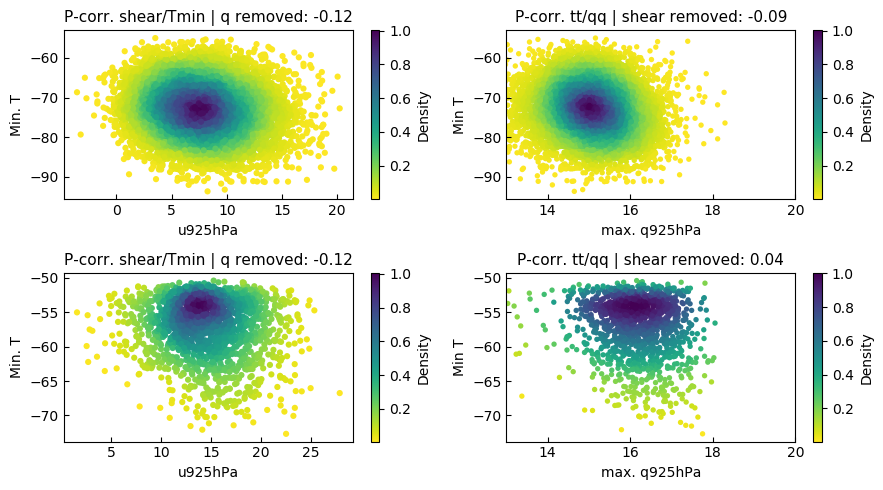

In [599]:
plot_scatter_month_double(ds_oct, cp25_oct)

In [628]:
alln=7
nbs= alln
nbq= alln
nba = alln

p1 = 5
p2 = 99

shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=np.percentile(ds_march.shear,p1)) & (ds_march.shear<=np.percentile(ds_march.shear,p2))], np.linspace(0,100,nbs)) #np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=np.percentile(cp4_march.shear,p1)) & (cp4_march.shear<=np.percentile(cp4_march.shear,p2))], np.linspace(0,100,nbs)) # np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
shear25_march = np.percentile(cp25_march.shear[(cp25_march.shear>=np.percentile(cp25_march.shear,p1)) & (cp25_march.shear<=np.percentile(cp25_march.shear,p2))], np.linspace(0,100,nbs)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))

shearb_oct = np.percentile(ds_oct.shear[(ds_oct.shear>=np.percentile(ds_oct.shear,p1)) & (ds_oct.shear<=np.percentile(ds_oct.shear,p2))], np.linspace(0,100,nbs)) #np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
shearc_oct = np.percentile(cp4_oct.shear[(cp4_oct.shear>=np.percentile(cp4_oct.shear,p1)) & (cp4_oct.shear<=np.percentile(cp4_oct.shear,p2))], np.linspace(0,100,nbs)) # np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
shear25_oct = np.percentile(cp25_oct.shear[(cp25_oct.shear>=np.percentile(cp25_oct.shear,p1)) & (cp25_oct.shear<=np.percentile(cp25_oct.shear,p2))], np.linspace(0,100,nbs)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))


abins = np.linspace(5000,250000, nba)
qbinsb_march = np.linspace(np.percentile(ds_march.q925, p1) , np.percentile(ds_march.q925, p2), nbq) 
qbinsc_march = np.linspace(np.percentile(cp4_march.q925, p1) , np.percentile(cp4_march.q925, p2), nbq)
qbinsc25_march = np.linspace(15 , np.percentile(cp25_march.q925, p2), nbq)

qbinsb_oct = np.linspace(np.percentile(ds_oct.q925, p1) , np.percentile(ds_oct.q925, p2), nbq) 
qbinsc_oct = np.linspace(np.percentile(cp4_oct.q925, p1) , np.percentile(cp4_oct.q925, p2), nbq)
qbinsc25_oct = np.linspace(15 , np.percentile(cp25_oct.q925, p2), nbq)

nbqq = 5
nbss = 5

p1 = 10
p2 = 90

shear_obsp = np.percentile(obsp.shear[(obsp.shear>=np.percentile(obsp.shear,1)) & (obsp.shear<=np.percentile(obsp.shear,99))], np.linspace(0,100,nbss)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))
#np.percentile(obsp.shear[(obsp.shear>=3) & (obsp.shear<=17)], np.linspace(0,100,nbss))
shear_cp4p = np.percentile(cp4p.shear[(cp4p.shear>=np.percentile(cp4p.shear,p1)) & (cp4p.shear<=np.percentile(cp4p.shear,p2))], np.linspace(0,100,nbss)) #np.percentile(cp4p.shear[(cp4p.shear>=8) & (cp4p.shear<=20)], np.linspace(0,100,nbss))
shear_cp25p = np.percentile(cp25p.shear[(cp25p.shear>=np.percentile(cp25p.shear,p1)) & (cp25p.shear<=np.percentile(cp25p.shear,p2))], np.linspace(0,100,nbss)) # np.percentile(cp25p.shear[(cp25p.shear>=8) & (cp25p.shear<=20)], np.linspace(0,100,nbss))

qbinso = np.linspace(np.percentile(obsp.q925, 1) , np.percentile(obsp.q925, 99), nbqq)
qbinsc= np.linspace(np.percentile(cp4p.q925, p1) , np.percentile(cp4p.q925, p2), nbqq)
qbinsc25 = np.linspace(15, np.percentile(cp25p.q925, p2), nbqq)


In [629]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mean = np.percentile(ds.tmean[poss_ds], 5)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.percentile(ds.prcp[poss_ds], 75)
            except:
                prcp_mean = np.nan

            try:
                ds_amean = np.percentile(ds.area[poss_ds], 75)
            except IndexError:
                ds_amean = np.nan

            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outarea_ds, outval

In [630]:
def create_2dhist_rh(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.rhtot>=qql) & (ds.rhtot < ybins[isq+1])
          
            try:
                ds_mean = np.percentile(ds.tmean[poss_ds], 5)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.percentile(ds.prcp[poss_ds], 75)
            except:
                prcp_mean = np.nan

            try:
                ds_amean = np.percentile(ds.area[poss_ds], 75)
            except IndexError:
                ds_amean = np.nan

            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outarea_ds, outval

In [631]:
def hist2d_plot(data,xbins, ybins, vmin, vmax, valid=None):
    f = plt.figure()
    ax5 = f.add_subplot(111)
    X, Y = np.meshgrid(xbins,ybins)
    cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
    if valid is not None:
        data[valid<50] = np.nan
    Zm = ma.masked_where(np.isnan(data),data)

    mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=vmin, vmax=vmax) # viridis_rvmin=20, vmax=40
    #mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp) # viridis_rvmin=20, vmax=40

    ax5.set_ylabel('Max. q925hPa')
    ax5.set_xlabel('Max. u925hPa (equally populated)')
    ax5.set_title('')
    cbar = f.colorbar(mappable, ticks=np.linspace(vmin,vmax,9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
    cbar.set_label('90th centile max. rain')
    plt.show()

In [632]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 

In [633]:
def hist2d_six(data, valid=False):
    f = plt.figure(figsize=(10,10))
    for i, dat in enumerate(data):
        ax = f.add_subplot(3,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
        if valid:
            
            dat['data'][dat['valid']<30] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/CLOVER/fig3.png')

In [634]:
dsperc_mar, dsp_mar, dsarea_mar, dsval_mar = create_2dhist(ds_march, shearb_march, qbinsb_march)
dsperc_oct, dsp_oct, dsarea_oct, dsval_oct = create_2dhist(ds_oct, shearb_oct, qbinsb_oct)

In [635]:
cp4perc_mar, cp4pr_mar, cp4area_mar, cp4val_mar = create_2dhist(cp4_march, shearc_march, qbinsc_march)
cp4perc_oct, cp4pr_oct, cp4area_oct, cp4val_oct = create_2dhist(cp4_oct, shearc_oct, qbinsc_oct)

In [636]:
cp25perc_mar, pc25pr_mar, cp25area_mar, cp25val_mar = create_2dhist(cp25_march, shear25_march, qbinsc25_march)
cp25perc_oct, pc25pr_oct, cp25area_oct, cp25val_oct = create_2dhist(cp25_oct, shear25_oct, qbinsc25_oct)

In [637]:
cpobsperc, pcobs, obsarea, obsval = create_2dhist_rh(obsp, shear_obsp, qbinso)
cp4perc, pc4, cp4area, cp4val = create_2dhist(cp4p, shear_cp4p, qbinsc)
cp25perc, pc25, cp25area, cp25val = create_2dhist(cp25p, shear_cp25p, qbinsc25)

In [638]:
pcobs.shape

(5, 5)

In [639]:
print(ds_march.shear.mean())
print(ds_march.q925.mean())

10.145094568785044
15.595371407285636


In [640]:
print(ds_oct.shear.mean())
print(ds_oct.q925.mean())

7.6289889958216275
15.026176996778801


In [641]:
ds_oct

,area,area70,lat,lon,month,q700,q925,qtot,rhtot,shear,tmean,tmin,u650,u925
508,11858.00,177.87,5.424999,8.510002,9.0,7.830621,15.309804,12.150951,86.548378,7.784724,-60.552841,-71.250000,-7.815222,-0.030498
509,20988.66,533.61,6.930000,9.525002,9.0,8.062644,13.905075,11.865288,75.472931,7.984220,-59.707787,-72.759995,-7.534166,0.450054
510,78855.70,474.32,5.704998,10.680000,9.0,8.088840,14.467103,11.979825,75.711006,2.274907,-58.469585,-71.369995,-2.397989,-0.123082
511,5691.84,296.45,7.139999,-0.589996,9.0,5.857741,14.792004,11.422447,83.908760,11.310610,-57.542389,-72.879990,-9.095960,2.214650
512,10553.62,0.00,4.514999,9.454994,9.0,8.021818,15.268298,12.331377,91.840172,11.734951,-56.371510,-67.089996,-8.307899,3.427052
513,9960.72,652.19,5.180000,8.615005,9.0,7.350584,15.308103,11.937638,85.344154,10.956809,-58.471184,-73.139999,-9.858671,1.098138
514,6462.61,1245.09,5.424999,10.645004,9.0,8.066386,14.435124,11.908268,81.871574,10.437680,-61.248352,-74.849991,-9.481724,0.955956
515,8952.79,59.29,5.845001,11.450005,9.0,8.614125,14.055449,11.999331,79.372047,12.702668,-56.719139,-70.099991,-12.243796,0.458871
516,5336.10,0.00,7.630001,5.779999,9.0,6.310221,15.126430,11.764019,80.693733,11.554193,-56.381660,-67.089996,-10.353552,1.200641
517,67946.34,4387.46,7.000000,11.904999,9.0,8.711766,18.294809,13.651845,90.270348,5.139483,-61.667690,-76.429993,-5.600935,-0.461452


In [642]:
ds_mar_dic = {
    'data' : dsperc_mar,
    'ybins' : qbinsb_march,
    'xbins' : shearb_march,
    'title' : 'MAM Observed',
    'valid' : dsval_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],1),
    'vmax' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}
ds_oct_dic = {
    'data' : dsperc_oct,
    'ybins' : qbinsb_oct,
    'xbins' : shearb_oct,
    'title' : 'SON observed',
    'valid' : dsval_oct,
    'cbarlabel' : '10th centile Tmean',
    'vmin' : np.percentile(dsperc_oct[(dsperc_oct!=0) & np.isfinite(dsperc_oct)],1),
    'vmax' : np.percentile(dsperc_oct[(dsperc_oct!=0) & np.isfinite(dsperc_oct)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

In [643]:
cp4_mar_dic = {
    'data' : cp4perc_mar,
    'ybins' : qbinsc_march,
    'xbins' : shearc_march,
    'title' : 'MAM CP4',
    'valid' : cp4val_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(cp4perc_mar[(cp4perc_mar!=0) & np.isfinite(cp4perc_mar)],1),
    'vmax' : np.percentile(cp4perc_mar[(cp4perc_mar!=0) & np.isfinite(cp4perc_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}


cp4_oct_dic = {
    'data' : cp4perc_oct,
    'ybins' : qbinsc_oct,
    'xbins' : shearc_oct,
    'title' : 'SON CP4',
    'valid' : cp4val_oct,
    'cbarlabel' : '10th centile Tmean',
    'vmin' : np.percentile(cp4perc_oct[(cp4perc_oct!=0) & np.isfinite(cp4perc_oct)],1),
    'vmax' : np.percentile(cp4perc_oct[(cp4perc_oct!=0) & np.isfinite(cp4perc_oct)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

In [644]:
cp25_mar_dic = {
    'data' : cp25perc_mar,
    'ybins' : qbinsc25_march,
    'xbins' : shear25_march,
    'title' : 'MAM P25',
    'valid' : cp25val_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(cp25perc_mar[(cp25perc_mar!=0) & np.isfinite(cp25perc_mar)],1),
    'vmax' : np.percentile(cp25perc_mar[(cp25perc_mar!=0) & np.isfinite(cp25perc_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

cp25_oct_dic = {
    'data' : cp25perc_oct,
    'ybins' : qbinsc25_oct,
    'xbins' : shear25_oct,
    'title' : 'SON P25',
    'valid' : cp25val_oct,
    'cbarlabel' : '10th centile Tmean',
    'vmin' : np.percentile(cp25perc_oct[(cp25perc_oct!=0) & np.isfinite(cp25perc_oct)],1),
    'vmax' : np.percentile(cp25perc_oct[(cp25perc_oct!=0) & np.isfinite(cp25perc_oct)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

In [647]:
cpobsperc

array([[nan, nan, nan, nan,  0.],
       [nan, nan, nan, nan,  0.],
       [nan, nan, nan, nan,  0.],
       [nan, nan, nan, nan,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [648]:
pcobs[pcobs==0]=np.nan
obsp_dic = {
    'data' : pcobs,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'OBS TRMM MSG',
    'valid' : obsval,
    'cbarlabel' : '95th centile precip',
    'vmin' : np.nanmin(pcobs) , #np.percentile(cp4perc_oct[(cp4perc_oct!=0) & np.isfinite(cp4perc_oct)],1),
    'vmax' : np.nanmax(pcobs) , #np.percentile(cp4perc_oct[(cp4perc_oct!=0) & np.isfinite(cp4perc_oct)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}
pc4[pc4==0]=np.nan
cp4_dic = {
    'data' : pc4,
    'ybins' : qbinsc,
    'xbins' : shear_cp4p,
    'title' : 'CP4',
    'valid' : cp4val,
    'cbarlabel' : '95th centile precip',
    'vmin' : np.nanmin(pc4), #np.percentile(cp4perc_oct[(cp4perc_oct!=0) & np.isfinite(cp4perc_oct)],1),
    'vmax' : np.nanmax(pc4), #np.percentile(cp4perc_oct[(cp4perc_oct!=0) & np.isfinite(cp4perc_oct)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}
pc25[pc25==0]=np.nan
cp25_dic = {
    'data' : pc25,
    'ybins' : qbinsc25,
    'xbins' : shear_cp25p,
    'title' : 'CP25',
    'valid' : cp25val,
    'cbarlabel' : '95th centile precip',
    'vmin' : np.nanmin(pc25), #np.percentile(cp4perc_oct[(cp4perc_oct!=0) & np.isfinite(cp4perc_oct)],1),
    'vmax' : np.nanmax(pc25), #np.percentile(cp4perc_oct[(cp4perc_oct!=0) & np.isfinite(cp4perc_oct)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':
/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: All-NaN slice encountered
  # Remove the CWD from sys.path while we load stuff.


(array([1.000e+00, 2.000e+00, 1.400e+01, 3.300e+01, 1.190e+02, 2.430e+02,
        4.730e+02, 8.860e+02, 1.550e+03, 1.063e+03]),
 array([-65.99490949, -64.40726555, -62.8196216 , -61.23197766,
        -59.64433371, -58.05668977, -56.46904582, -54.88140187,
        -53.29375793, -51.70611398, -50.11847004]),
 <a list of 10 Patch objects>)

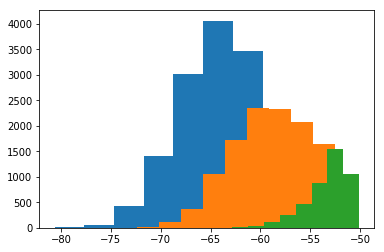

In [649]:
plt.hist(ds_march.tmean)
plt.hist(cp4_march.tmean)
plt.hist(cp25_march.tmean)

In [650]:
data_list = [ds_mar_dic, ds_oct_dic, cp4_mar_dic, cp4_oct_dic, cp25_mar_dic, cp25_oct_dic]

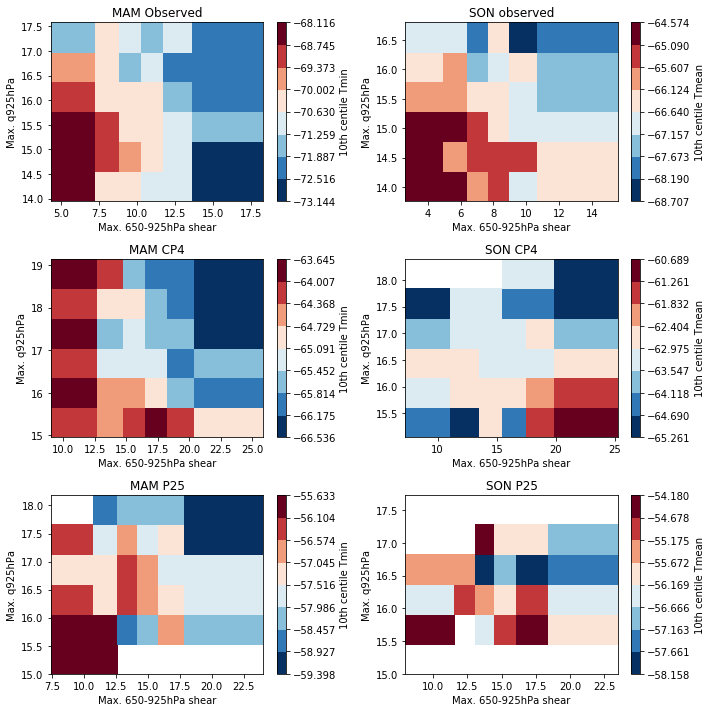

In [651]:
hist2d_six(data_list, valid=True)

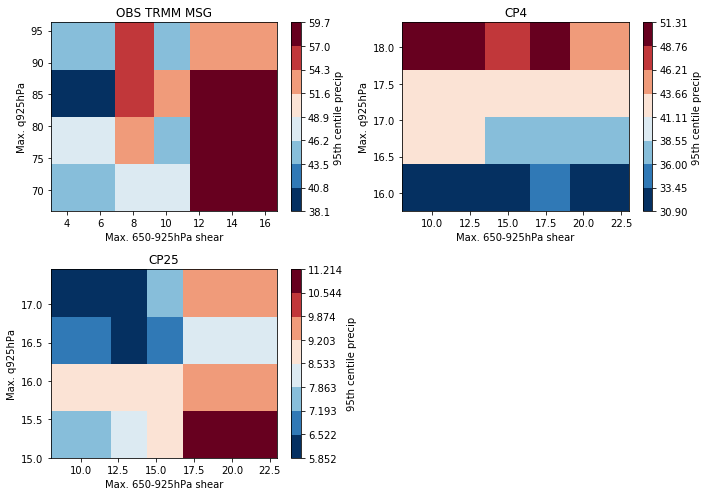

In [526]:
data_list = [obsp_dic, cp4_dic, cp25_dic]
hist2d_quatro(data_list,valid=True)

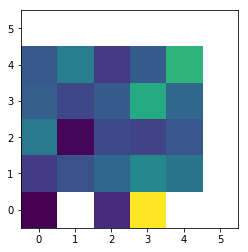

In [2516]:
plt.imshow(obsp_dic['data'].T, origin='lower')

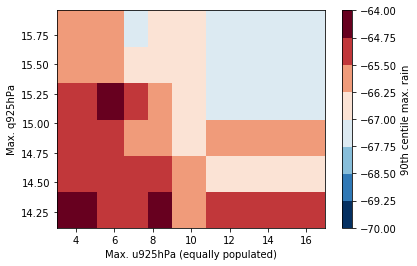

In [2517]:
hist2d_plot(dsperc_oct, shearb_oct, qbinsb_oct, vmin=-70, vmax=-64)